In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, r2_score,accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import HistGradientBoostingRegressor
import random
import re

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## CROP DATA CLEANING

### 1. Data Loading and Raw Data Cleaning

In [ ]:
df = pd.read_csv(r"/content/Crops_output_2.csv", low_memory=False)

df.dropna(axis=1, how='all', inplace=True)
df.drop(columns=['Program', 'watershed_code', 'Domain Category', 'Week Ending', 'State ANSI'], inplace=True, errors='ignore')

In [ ]:
df.head()

,Year,Period,Geo Level,State,Commodity,Data Item,Domain,Value
0,2001,April,STATE,ARIZONA,HAY,"HAY - PRICE RECEIVED, MEASURED IN $ / TON",TOTAL,100
1,2001,April,STATE,ARIZONA,HAY,"HAY, (EXCL ALFALFA) - PRICE RECEIVED, MEASURED...",TOTAL,90
2,2001,April,STATE,ARIZONA,HAY,"HAY, ALFALFA - PRICE RECEIVED, MEASURED IN $ /...",TOTAL,100
3,2001,April,STATE,ARKANSAS,COTTON,"COTTON, UPLAND - PRICE RECEIVED, MEASURED IN $...",TOTAL,0.515
4,2001,April,STATE,ARKANSAS,SORGHUM,"SORGHUM, GRAIN - PRICE RECEIVED, MEASURED IN $...",TOTAL,3.66


In [ ]:
exclude_commodities = [
    'PASTURELAND', 'GRAIN STORAGE CAPACITY', 'FIELD CROP TOTALS', 'HAY & HAYLAGE',
    'MAPLE SYRUP', 'GRAIN', 'LEGUMES', 'HEMP'
]

In [ ]:
df = df[~df['Commodity'].isin(exclude_commodities)]
df = df[~df["Data Item"].str.contains(r"(COTTON - NUMBER OF ACTIVE GINS|NUMBER OF SAMPLES|ACRES REMAINING TO BE PLANTED|ACRES (?:PLANTED|HARVESTED))", case=False, regex=True, na=False)]

### 2. Extracting Metrics & Standardizing Value Formats

In [ ]:
df[["Item", "Metric", "Measurement_Unit"]] = df["Data Item"].str.extract(r"(.+?) - (.+?), (.+)?", expand=True)
df['Unit_Extracted'] = df['Measurement_Unit'].str.extract(r"MEASURED IN \$ / (\w+)", expand=True)

In [ ]:
df['Value'] = df['Value'].astype(str).str.replace(',', '', regex=True)
df['Value'] = df['Value'].replace([r"\(.*?\)", r"[A-Za-z]"], np.nan, regex=True)
df['Value'] = pd.to_numeric(df['Value'])

In [ ]:
conversion_factors = {
    "TON": 1, "LB": 2000, "CWT": 20,
    "BU": {
        "corn": 35.7, "wheat": 33.3, "soybeans": 33.3, "oats": 62.5,
        "barley": 41.7, "sorghum": 35.7, "rice": 44.4, "peanuts": 25.0,
        "sunflower": 42.0, "flaxseed": 52.1, "rye": 36.0, "millet": 50.0,
        "lentils": 60.0, "peas": 60.0, "canola": 50.0, "chickpeas": 60.0,
        "mustard": 50.0, "safflower": 50.0, "camelina": 50.0, "rapeseed": 50.0
    }
}

In [ ]:
def convert_to_ton(value, unit, commodity):
    if pd.isna(value) or pd.isna(unit): return value
    unit = unit.strip().upper()
    if unit == "TON": return value
    elif unit == "LB": return value * conversion_factors["LB"]
    elif unit == "CWT": return value * conversion_factors["CWT"]
    elif unit == "BU":
        factor = conversion_factors["BU"].get(commodity.lower().strip(), 35.7)
        return value * factor
    return value

In [ ]:
df['PRICE_IN_TON'] = df.apply(
    lambda row: convert_to_ton(row['Value'], row['Unit_Extracted'], row['Commodity'])
    if row['Metric'] == 'PRICE RECEIVED' else row['Value'], axis=1
)

In [ ]:
df['Pivot_Value'] = df.apply(lambda row: row['PRICE_IN_TON'] if row['Metric'] == 'PRICE RECEIVED' else row['Value'], axis=1)

### 3. Pivoting the DataFrame for Metric-wise Columns

In [ ]:
pivot_df = df.pivot_table(
    index=["Year", "Period", "Geo Level", "State", "Commodity"],
    columns="Metric",
    values="Pivot_Value",
    aggfunc="first"
).reset_index()

pivot_df.columns.name = None
pivot_df.columns = [str(col) for col in pivot_df.columns]

In [ ]:
pivot_df.head()

,Year,Period,Geo Level,State,Commodity,CONDITION,EAR COUNT,PLANT POPULATION,POD COUNT,PRICE RECEIVED,PRODUCTION,PROGRESS,SALES,STOCKS,SUCROSE,YIELD
0,2001,April,STATE,ALABAMA,COTTON,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2001,April,STATE,ALABAMA,SORGHUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
2,2001,April,STATE,ALABAMA,SOYBEANS,NaN,NaN,NaN,NaN,NaN,21735000.0,NaN,NaN,NaN,NaN,NaN
3,2001,April,STATE,ALASKA,HAY,NaN,NaN,NaN,NaN,NaN,30000.0,NaN,NaN,NaN,NaN,NaN
4,2001,April,STATE,ARIZONA,BARLEY,NaN,NaN,NaN,NaN,NaN,4400000.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
selected_columns = [
    'Year', 'Period', 'Geo Level', 'State', 'Commodity',
    'CONDITION', 'PROGRESS', 'PRICE RECEIVED', 'STOCKS',
    'SALES', 'YIELD'
]


df = pivot_df[selected_columns]

In [ ]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36996 entries, 0 to 36995
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              36996 non-null  int64  
 1   Period            36996 non-null  object 
 2   Geo Level         36996 non-null  object 
 3   State             36996 non-null  object 
 4   Commodity         36996 non-null  object 
 5   CONDITION         5694 non-null   float64
 6   EAR COUNT         340 non-null    float64
 7   PLANT POPULATION  345 non-null    float64
 8   POD COUNT         366 non-null    float64
 9   PRICE RECEIVED    20031 non-null  float64
 10  PRODUCTION        13990 non-null  float64
 11  PROGRESS          8760 non-null   float64
 12  SALES             15906 non-null  float64
 13  STOCKS            8176 non-null   float64
 14  SUCROSE           152 non-null    float64
 15  YIELD             16303 non-null  float64
dtypes: float64(11), int64(1), object(4)
memo

### 4. Handling Missing Values & Outliers

In [ ]:
df_2 = df.dropna()

In [ ]:
targets = ['YIELD', 'SALES', 'STOCKS', 'PRICE RECEIVED', 'PROGRESS', 'CONDITION']
cats = ['Year', 'Period', 'Geo Level', 'State', 'Commodity']

train_df = df_2.copy()
full_df = df.copy()


encoders = {}
for col in cats:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], full_df[col]]).astype(str)
    le.fit(combined)
    train_df[col + "_enc"] = le.transform(train_df[col].astype(str))
    full_df[col + "_enc"] = le.transform(full_df[col].astype(str))
    encoders[col] = le

In [ ]:
for target in targets:
    features = [col + "_enc" for col in cats] + [t for t in targets if t != target]

    # Train
    valid = train_df[target].notnull()
    model = HistGradientBoostingRegressor(random_state=42)
    model.fit(train_df.loc[valid, features], train_df.loc[valid, target])

    # Impute
    mask = full_df[target].isnull()
    if mask.any():
        X_full = full_df.loc[mask, features].fillna(full_df[features].median())
        full_df.loc[mask, target] = model.predict(X_full)
        print(f"Filled {mask.sum()} missing in {target}")

print("Imputation complete. Original categoricals preserved.")

Filled 20693 missing in YIELD
Filled 21090 missing in SALES
Filled 28820 missing in STOCKS
Filled 16965 missing in PRICE RECEIVED
Filled 28236 missing in PROGRESS
Filled 31302 missing in CONDITION
Imputation complete. Original categoricals preserved.


In [ ]:
columns = ['Year_enc', 'Period_enc', 'Geo Level_enc', 'State_enc', 'Commodity_enc']
df = full_df.drop(columns=columns)

In [ ]:
df.head()

,Year,Period,Geo Level,State,Commodity,CONDITION,PROGRESS,PRICE RECEIVED,STOCKS,SALES,YIELD
0,2001,April,STATE,ALABAMA,COTTON,14.140374,0.000000,171.505687,-6.116894e+06,17.802180,102.573105
1,2001,April,STATE,ALABAMA,SORGHUM,10.875838,82.791110,82.548021,2.204526e+07,14.127649,9.000000
2,2001,April,STATE,ALABAMA,SOYBEANS,9.813286,39.788198,194.858975,1.560384e+07,13.777667,34.278862
3,2001,April,STATE,ALASKA,HAY,10.558595,92.969141,111.173337,-5.785854e+06,18.223306,99.223375
4,2001,April,STATE,ARIZONA,BARLEY,10.558595,92.969141,111.173337,-5.785854e+06,18.223306,99.223375


In [ ]:
df.to_csv(r"/content/crop_data_to_merge.csv")

## Soild Data Cleaning

### 1. Data Loading & Cleaning

In [ ]:
soil_path = r"/content/soil_2000_2024.csv"
soil_df = pd.read_csv(soil_path, low_memory=False)

In [ ]:
soil_df.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Commodity,Data Item,Domain,...,drainagecl,lep_l,slope_l,slope_r,slope_h,elev_l,elev_r,elev_h,mukey,hydricrating
0,SURVEY,2025,WEEK #01,05-01-2025,STATE,ARIZONA,4,SOIL,"SOIL, SUBSOIL - MOISTURE, MEASURED IN PCT SHORT",TOTAL,...,Well drained,3.0,5.0,7.0,9.0,213.0,335.0,457.0,667263,No
1,SURVEY,2025,WEEK #01,05-01-2025,STATE,ARKANSAS,5,SOIL,"SOIL, SUBSOIL - MOISTURE, MEASURED IN PCT SHORT",TOTAL,...,Well drained,NaN,25.0,33.0,40.0,213.0,335.0,457.0,667263,No
2,SURVEY,2025,WEEK #01,05-01-2025,STATE,CALIFORNIA,6,SOIL,"SOIL, SUBSOIL - MOISTURE, MEASURED IN PCT SHORT",TOTAL,...,Well drained,0.0,9.0,12.0,14.0,213.0,335.0,457.0,667263,No
3,SURVEY,2025,WEEK #01,05-01-2025,STATE,COLORADO,8,SOIL,"SOIL, SUBSOIL - MOISTURE, MEASURED IN PCT SHORT",TOTAL,...,NaN,3.0,25.0,43.0,60.0,NaN,NaN,NaN,667263,No
4,SURVEY,2025,WEEK #01,05-01-2025,STATE,FLORIDA,12,SOIL,"SOIL, SUBSOIL - MOISTURE, MEASURED IN PCT SHORT",TOTAL,...,Well drained,3.0,5.0,7.0,9.0,213.0,335.0,457.0,667263,No


In [ ]:
columns_to_keep = [
    'Year', 'Period', 'State', 'Value', 'sandtotal_r', 'silttotal_r', 'claytotal_r',
    'ph1to1h2o_r', 'cec7_r', 'om_r', 'awc_r', 'ksat_r',
    'drainagecl', 'slope_r', 'elev_r'
]
soil_df = soil_df[columns_to_keep]

In [ ]:
rename_map = {
    'Value': 'Moisture',
    'sandtotal_r': 'sand_per',
    'silttotal_r': 'slit_per',
    'claytotal_r': 'clay_per',
    'ph1to1h2o_r': 'ph',
    'cec7_r': 'Cation Exchange Capacity',
    'om_r': 'Organic Matter',
    'awc_r': 'Available Water Capacity',
    'ksat_r': 'ksat',
    'drainagecl': 'Drainage Class',
    'slope_r': 'slope',
    'elev_r': 'elev'
}
soil_df.rename(columns=rename_map, inplace=True)

In [ ]:
soil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33441 entries, 0 to 33440
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      33441 non-null  int64  
 1   Period                    33441 non-null  object 
 2   State                     33441 non-null  object 
 3   Moisture                  33441 non-null  float64
 4   sand_per                  28061 non-null  float64
 5   slit_per                  28066 non-null  float64
 6   clay_per                  29633 non-null  float64
 7   ph                        29681 non-null  float64
 8   Cation Exchange Capacity  22792 non-null  float64
 9   Organic Matter            24373 non-null  float64
 10  Available Water Capacity  29728 non-null  float64
 11  ksat                      30375 non-null  float64
 12  Drainage Class            32467 non-null  object 
 13  slope                     33292 non-null  float64
 14  elev  

### 2.Handling Missing Values & Outliers

In [ ]:
numeric_cols = [
    'sand_per', 'slit_per', 'clay_per', 'ph', 'Cation Exchange Capacity', 'Organic Matter',
    'Available Water Capacity', 'ksat', 'slope', 'elev'
]

log_cols = ['Cation Exchange Capacity', 'Organic Matter', 'ksat']

In [ ]:
for col in numeric_cols:
    if soil_df[col].isna().sum() > 0:
        lower, upper = np.percentile(soil_df[col].dropna(), [10, 95])
        rand_fill = np.random.uniform(lower, upper, size=soil_df[col].isna().sum())
        soil_df.loc[soil_df[col].isna(), col] = rand_fill

    # Clip to 1st–99th percentile
    clip_low, clip_high = np.percentile(soil_df[col], [1, 99])
    soil_df[col] = np.clip(soil_df[col], clip_low, clip_high)

    # Log transform
    if col in log_cols:
        soil_df[col] = np.log1p(soil_df[col])

In [ ]:
drainage_classes = [
    "Well drained", "Somewhat excessively drained", "Moderately well drained",
    "Somewhat poorly drained", "Excessively drained", "Poorly drained", "Very poorly drained"
]

soil_df['Drainage Class'] = soil_df['Drainage Class'].apply(lambda x: random.choice(drainage_classes) if pd.isna(x) else x)

In [ ]:
soil_df.isnull().sum()

,0
Year,0
Period,0
State,0
Moisture,0
sand_per,0
slit_per,0
clay_per,0
ph,0
Cation Exchange Capacity,0
Organic Matter,0


### 3.Handling the Period Values

In [ ]:
def convert_to_month(period):
    period = period.upper()

    week_match = re.search(r"WEEK\s*#(\d{1,2})", period)
    if week_match:
        week = int(week_match.group(1))
        # Approximate week to month
        month_by_week = {
            1: "January", 5: "February", 9: "March", 13: "April", 17: "May", 21: "June", 26: "July", 30: "August", 35: "September",
            40: "October", 45: "November", 49: "December"
        }
        for wk in sorted(month_by_week.keys(), reverse=True):
            if week >= wk:
                return month_by_week[wk]

In [ ]:
soil_df['Period'] = soil_df['Period'].apply(convert_to_month)

In [ ]:
soil_df.head()

,Year,Period,State,Moisture,sand_per,slit_per,clay_per,ph,Cation Exchange Capacity,Organic Matter,Available Water Capacity,ksat,Drainage Class,slope,elev
0,2025,January,ARIZONA,22.0,55.500000,14.500000,30.000000,5.300000,2.510834,0.223144,0.14000,2.319865,Well drained,7.0,335.0000
1,2025,January,ARKANSAS,4.0,31.426256,25.509004,30.338536,6.111638,2.863076,1.486223,0.08093,3.361533,Well drained,33.0,335.0000
2,2025,January,CALIFORNIA,5.0,41.599998,37.400002,21.000000,6.100000,2.525729,1.504077,0.12000,2.319865,Well drained,12.0,335.0000
3,2025,January,COLORADO,24.0,35.400002,33.599998,31.000000,5.600000,2.940222,1.115680,0.13000,2.319865,Poorly drained,43.0,1358.9196
4,2025,January,FLORIDA,22.0,35.400002,33.599998,31.000000,5.600000,3.499369,0.622101,0.17000,2.319865,Well drained,7.0,335.0000


In [ ]:
soil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33441 entries, 0 to 33440
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      33441 non-null  int64  
 1   Period                    33441 non-null  object 
 2   State                     33441 non-null  object 
 3   Moisture                  33441 non-null  float64
 4   sand_per                  33441 non-null  float64
 5   slit_per                  33441 non-null  float64
 6   clay_per                  33441 non-null  float64
 7   ph                        33441 non-null  float64
 8   Cation Exchange Capacity  33441 non-null  float64
 9   Organic Matter            33441 non-null  float64
 10  Available Water Capacity  33441 non-null  float64
 11  ksat                      33441 non-null  float64
 12  Drainage Class            33441 non-null  object 
 13  slope                     33441 non-null  float64
 14  elev  

In [ ]:
soil_df.to_csv(r'C:\Users\narra\Downloads\soil_to_merge.csv')

## Consolidating Data for Exploratory Analysis and Modeling

In [ ]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')      # Convert to numeric
df['State'] = df['State'].astype(str).str.strip().str.title()
df['Period'] = df['Period'].astype(str).str.strip().str.title()

# STEP 2: Clean and convert soil_df
soil_df['Year'] = pd.to_numeric(soil_df['Year'], errors='coerce')
soil_df['State'] = soil_df['State'].astype(str).str.strip().str.title()
soil_df['Period'] = soil_df['Period'].astype(str).str.strip().str.title()

In [ ]:
# Grouping the data
soil_grouped = soil_df.groupby(['Year', 'State', 'Period']).mean(numeric_only=True).reset_index()

In [ ]:
# Preparing fallback tables
soil_yr_state = soil_grouped.groupby(['Year', 'State']).mean(numeric_only=True).reset_index()
soil_state = soil_grouped.groupby(['State']).mean(numeric_only=True).reset_index()

In [ ]:
merged_df = pd.merge(df, soil_grouped, on=['Year', 'State', 'Period'], how='left')

In [ ]:
for col in soil_grouped.columns:
    if col not in ['Year', 'State', 'Period']:
        fallback1 = df[['Year', 'State']].merge(soil_yr_state[['Year', 'State', col]], on=['Year', 'State'], how='left')[col]

        fallback2 = df[['State']].merge(soil_state[['State', col]], on='State', how='left')[col]

        merged_df[col] = merged_df[col].fillna(fallback1).fillna(fallback2)

In [ ]:
for col in merged_df.select_dtypes(include='number'):
    if merged_df[col].isna().any():
        q25, q75 = merged_df[col].quantile([0.25, 0.75])
        missing = merged_df[col].isna()
        merged_df.loc[missing, col] = np.random.uniform(q25, q75, size=missing.sum())

In [ ]:
merged_df.isna().sum()

,0
Year,0
Period,0
Geo Level,0
State,0
Commodity,0
CONDITION,0
PROGRESS,0
PRICE RECEIVED,0
STOCKS,0
SALES,0


In [ ]:
numeric_cols = merged_df.select_dtypes(include='number').columns

merged_df[numeric_cols] = merged_df[numeric_cols].clip(lower=0)

In [ ]:
merged_df.describe()

,Year,CONDITION,PROGRESS,PRICE RECEIVED,STOCKS,SALES,YIELD,Moisture,sand_per,slit_per,clay_per,ph,Cation Exchange Capacity,Organic Matter,Available Water Capacity,ksat,slope,elev
count,36996.000000,36996.000000,36996.000000,36996.000000,3.699600e+04,36996.000000,36996.000000,36996.000000,36996.000000,36996.000000,36996.000000,36996.000000,36996.000000,36996.000000,36996.000000,36996.000000,36996.000000,36996.000000
mean,2005.835550,11.142230,60.304411,282.291310,5.752052e+07,9.466573,318.570850,22.563665,34.372601,43.182544,23.560597,6.723263,2.811476,0.847824,0.153258,2.235635,6.455231,721.186145
std,3.078649,6.075732,27.013644,1492.292411,8.843127e+07,8.027331,852.537921,11.168882,12.521381,9.043680,5.621109,0.474574,0.213959,0.206903,0.024894,0.515596,3.397713,243.486850
min,2001.000000,0.000000,0.000000,5.300000,0.000000e+00,0.000000,0.000000,0.000000,5.300000,1.400000,2.500000,5.000000,1.252763,0.095310,0.030000,0.190620,1.000000,9.000000
25%,2003.000000,6.888395,43.592028,97.236000,1.044150e+07,4.000000,39.000000,14.047159,24.849999,38.037371,20.713779,6.450000,2.742131,0.789805,0.135137,1.993580,3.600000,578.927386
50%,2006.000000,10.249805,65.785596,138.000000,3.509069e+07,7.103077,69.695999,21.064286,39.055280,40.366758,21.637895,6.886164,2.773363,0.857881,0.146000,2.403293,7.770833,801.879632
75%,2008.000000,14.734434,81.579868,199.330031,7.019296e+07,12.669399,124.385463,31.530556,42.912956,48.971259,25.875000,7.070316,2.897408,0.901173,0.170000,2.508097,8.558201,842.729984
max,2011.000000,100.000000,111.025255,56000.000000,2.177545e+09,100.000000,8740.000000,88.800000,94.900002,72.180002,50.000000,8.500000,3.725693,1.945910,0.230000,4.956812,35.000000,1961.588146


## Generating Soil Labels

In [ ]:
def classify_texture(row):
    sand, silt, clay = row['sand_per'], row['slit_per'], row['clay_per']

    if sand >= 70 and clay <= 15:
        return 'Sandy'
    elif clay >= 35:
        return 'Clayey'
    elif silt >= 50 and sand < 30:
        return 'Silty'
    elif 25 <= clay <= 35 and sand >= 30 and silt >= 20:
        return 'Loamy'
    return 'Loamy'

In [ ]:
def classify_fertility(row):
    om = row['Organic Matter']
    awc = row['Available Water Capacity']
    cec = row['Cation Exchange Capacity']
    ph = row['ph']
    slope = row['slope']

    if om >= 1.25 and awc >= 0.18 and cec >= 3 and 6 <= ph <= 7.5 and slope < 10:
        return 'High Fertility'
    elif om < 0.5 or awc < 0.1 or ph < 5.8 or slope > 20:
        return 'Low Fertility'
    else:
        return 'Moderate Fertility'

In [ ]:
merged_df['Soil_Texture'] = merged_df.apply(classify_texture, axis=1)

In [ ]:
merged_df['Soil_Fertility'] = merged_df.apply(classify_fertility, axis=1)

In [ ]:
merged_df.head()

,Year,Period,Geo Level,State,Commodity,CONDITION,PROGRESS,PRICE RECEIVED,STOCKS,SALES,...,clay_per,ph,Cation Exchange Capacity,Organic Matter,Available Water Capacity,ksat,slope,elev,Soil_Texture,Soil_Fertility
0,2001,April,STATE,Alabama,COTTON,14.140374,0.000000,171.505687,0.000000e+00,17.802180,...,20.021587,7.161967,2.717480,0.815146,0.132940,2.527574,8.729808,872.882243,Loamy,Moderate Fertility
1,2001,April,STATE,Alabama,SORGHUM,10.875838,82.791110,82.548021,2.204526e+07,14.127649,...,20.021587,7.161967,2.717480,0.815146,0.132940,2.527574,8.729808,872.882243,Loamy,Moderate Fertility
2,2001,April,STATE,Alabama,SOYBEANS,9.813286,39.788198,194.858975,1.560384e+07,13.777667,...,20.021587,7.161967,2.717480,0.815146,0.132940,2.527574,8.729808,872.882243,Loamy,Moderate Fertility
3,2001,April,STATE,Alaska,HAY,10.558595,92.969141,111.173337,0.000000e+00,18.223306,...,25.922520,6.501693,2.847279,0.799329,0.150980,2.159634,5.614970,609.632449,Loamy,Moderate Fertility
4,2001,April,STATE,Arizona,BARLEY,10.558595,92.969141,111.173337,0.000000e+00,18.223306,...,21.637895,7.038020,2.777498,0.919828,0.136805,2.513666,8.558201,820.282291,Loamy,Moderate Fertility


## EDA

In [ ]:
sns.set(style="whitegrid", palette="muted")

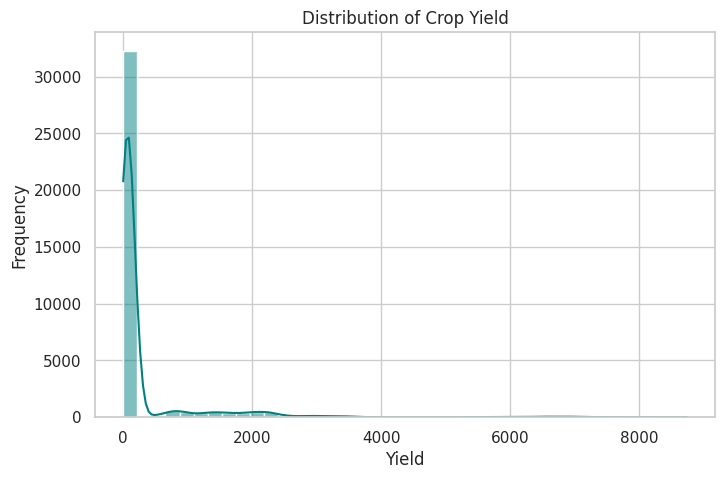

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['YIELD'], kde=True, bins=40, color='teal')
plt.title("Distribution of Crop Yield")
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.show()

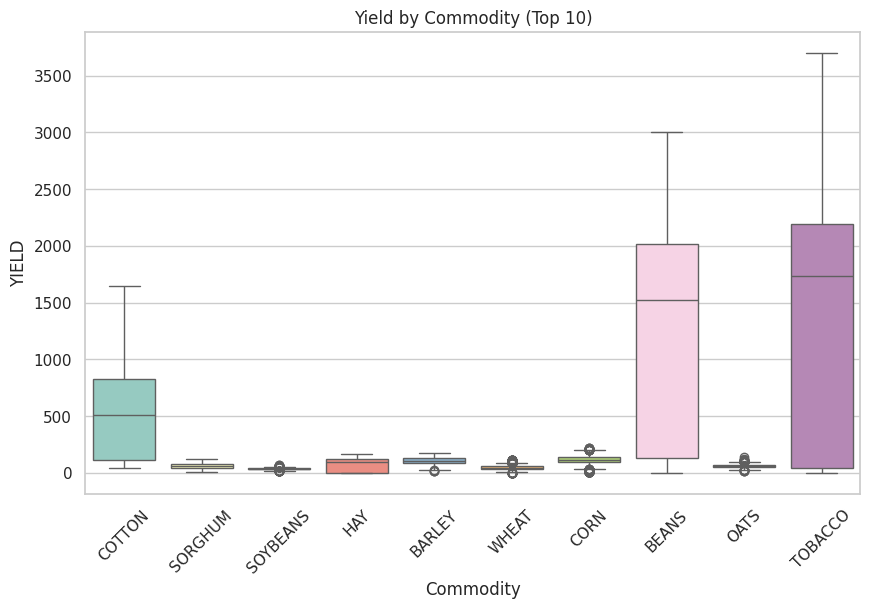

In [ ]:
top_commodities = merged_df['Commodity'].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df[merged_df['Commodity'].isin(top_commodities)],
            x='Commodity', y='YIELD', palette='Set3')
plt.title("Yield by Commodity (Top 10)")
plt.xticks(rotation=45)
plt.show()

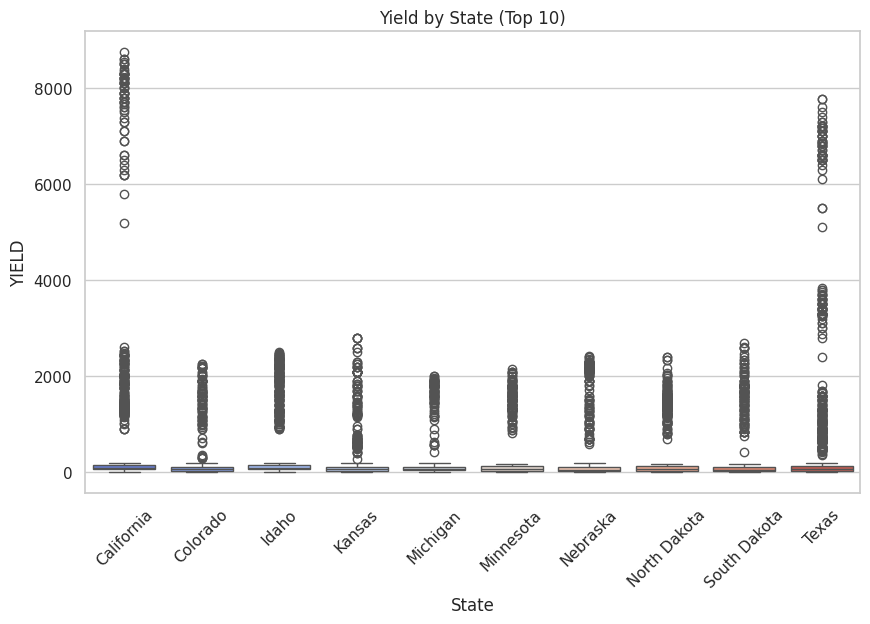

In [ ]:
top_states = merged_df['State'].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df[merged_df['State'].isin(top_states)],
            x='State', y='YIELD', palette='coolwarm')
plt.title("Yield by State (Top 10)")
plt.xticks(rotation=45)
plt.show()

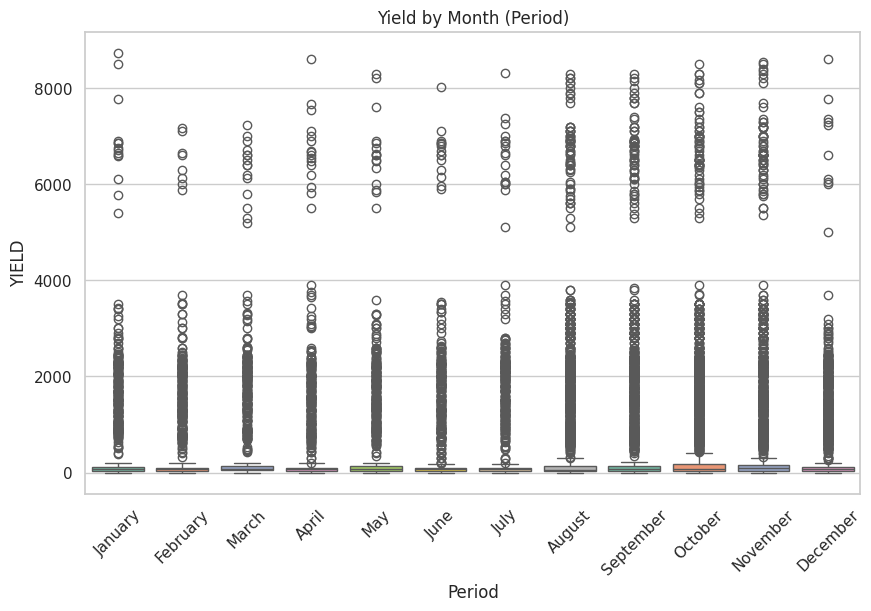

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='Period', y='YIELD', palette='Set2',
            order=['January','February','March','April','May','June',
                   'July','August','September','October','November','December'])
plt.title("Yield by Month (Period)")
plt.xticks(rotation=45)
plt.show()

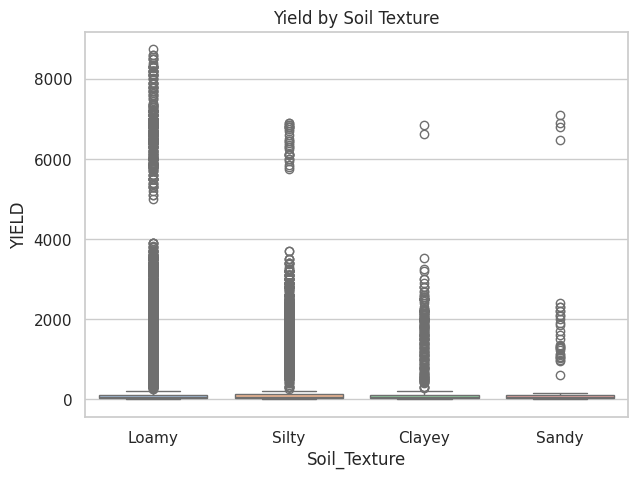

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x='Soil_Texture', y='YIELD', palette='pastel')
plt.title("Yield by Soil Texture")
plt.show()

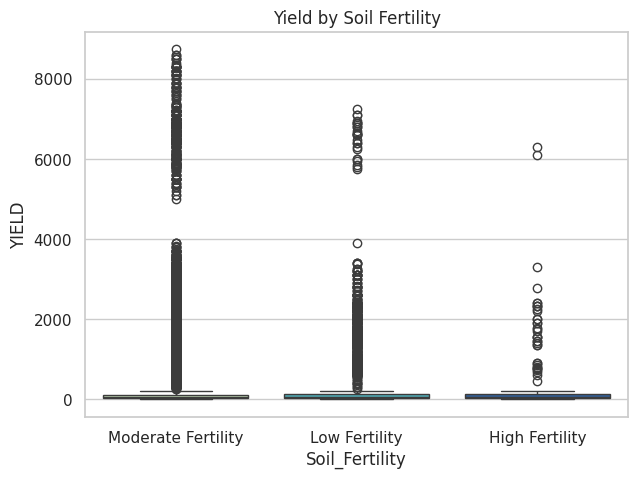

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x='Soil_Fertility', y='YIELD', palette='YlGnBu')
plt.title("Yield by Soil Fertility")
plt.show()

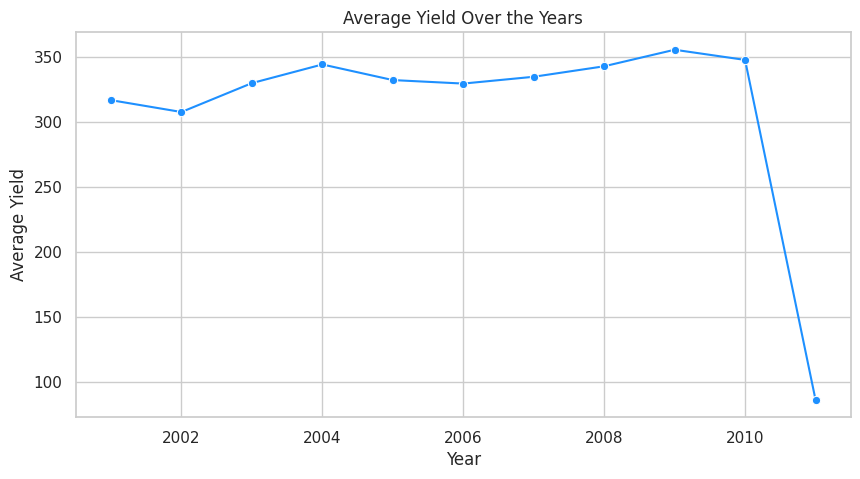

In [ ]:
yearly_avg = merged_df.groupby('Year')['YIELD'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_avg, x='Year', y='YIELD', marker='o', color='dodgerblue')
plt.title("Average Yield Over the Years")
plt.ylabel("Average Yield")
plt.xlabel("Year")
plt.show()

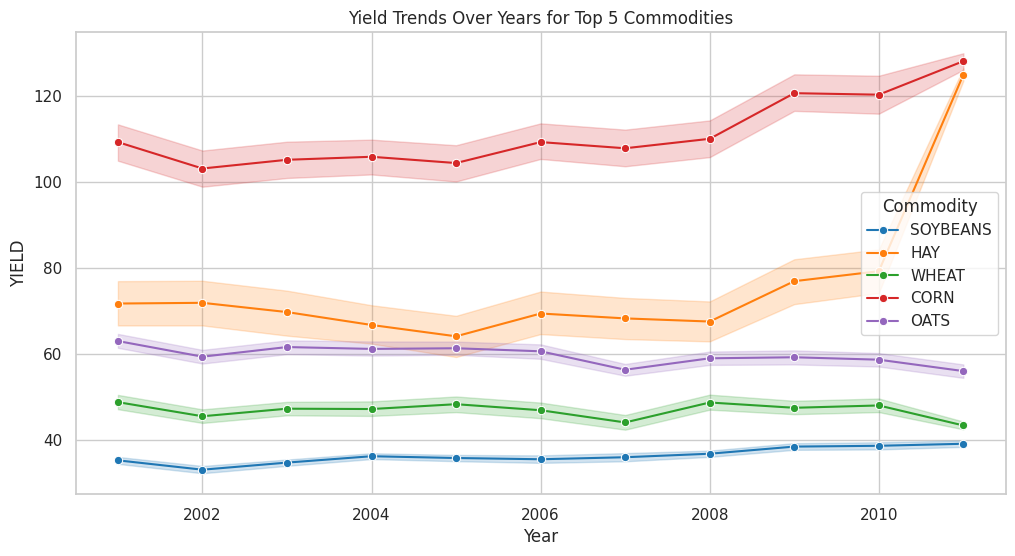

In [ ]:
top5_commodities = merged_df['Commodity'].value_counts().head(5).index
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df[merged_df['Commodity'].isin(top5_commodities)],
             x='Year', y='YIELD', hue='Commodity', marker='o', palette='tab10')
plt.title("Yield Trends Over Years for Top 5 Commodities")
plt.show()

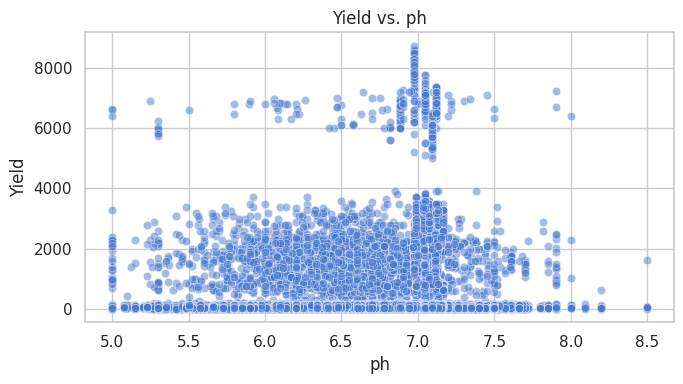

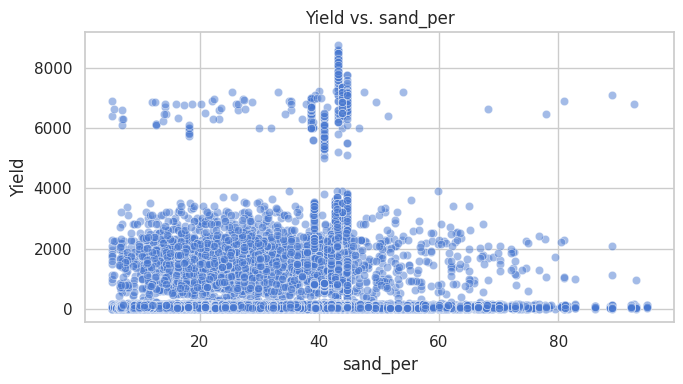

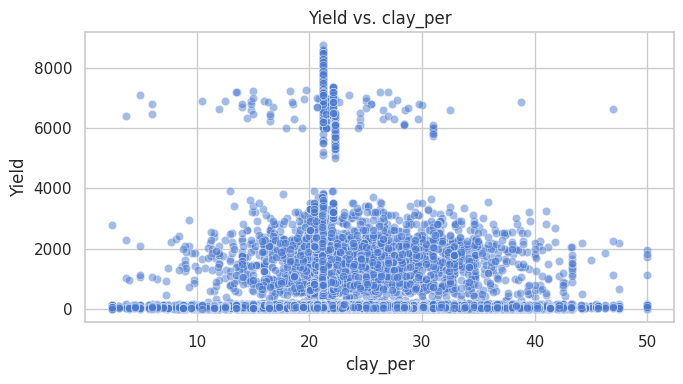

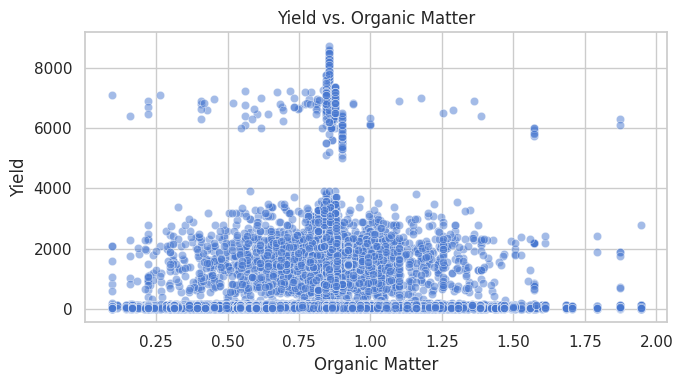

In [ ]:
soil_features = ['ph', 'sand_per', 'clay_per', 'Organic Matter']
for feature in soil_features:
    plt.figure(figsize=(7, 4))
    sns.scatterplot(data=merged_df, x=feature, y='YIELD', alpha=0.5)
    plt.title(f"Yield vs. {feature}")
    plt.xlabel(feature)
    plt.ylabel("Yield")
    plt.tight_layout()
    plt.show()

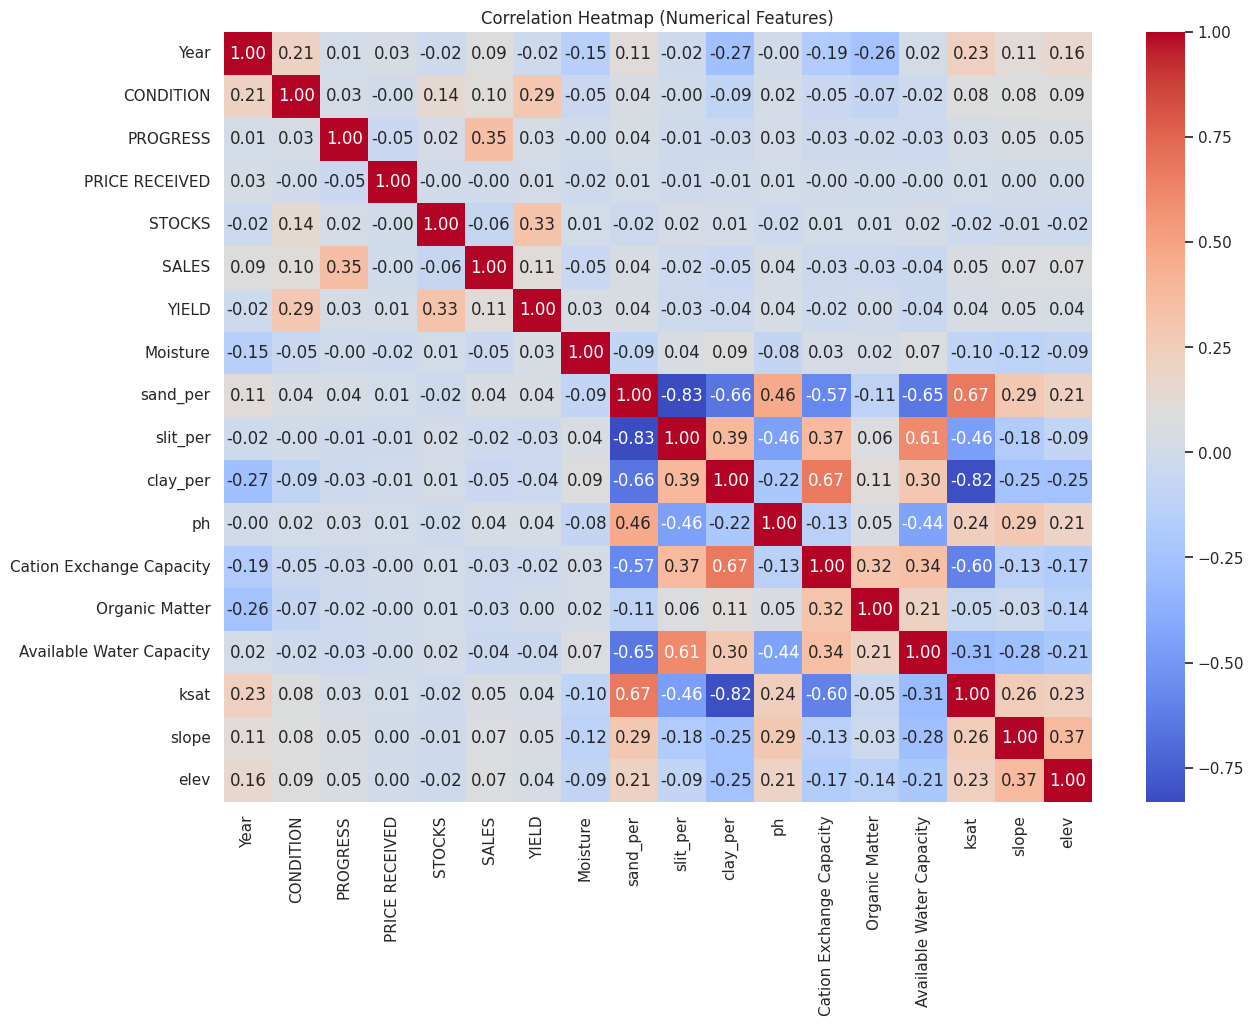

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(merged_df.select_dtypes(include='number').corr(),
            cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

**Machine Learning**

In [ ]:
merged_df.head()

,Year,Period,Geo Level,State,Commodity,CONDITION,PROGRESS,PRICE RECEIVED,STOCKS,SALES,...,clay_per,ph,Cation Exchange Capacity,Organic Matter,Available Water Capacity,ksat,slope,elev,Soil_Texture,Soil_Fertility
0,2001,April,STATE,Alabama,COTTON,14.140374,0.000000,171.505687,0.000000e+00,17.802180,...,20.021587,7.161967,2.717480,0.815146,0.132940,2.527574,8.729808,872.882243,Loamy,Moderate Fertility
1,2001,April,STATE,Alabama,SORGHUM,10.875838,82.791110,82.548021,2.204526e+07,14.127649,...,20.021587,7.161967,2.717480,0.815146,0.132940,2.527574,8.729808,872.882243,Loamy,Moderate Fertility
2,2001,April,STATE,Alabama,SOYBEANS,9.813286,39.788198,194.858975,1.560384e+07,13.777667,...,20.021587,7.161967,2.717480,0.815146,0.132940,2.527574,8.729808,872.882243,Loamy,Moderate Fertility
3,2001,April,STATE,Alaska,HAY,10.558595,92.969141,111.173337,0.000000e+00,18.223306,...,25.922520,6.501693,2.847279,0.799329,0.150980,2.159634,5.614970,609.632449,Loamy,Moderate Fertility
4,2001,April,STATE,Arizona,BARLEY,10.558595,92.969141,111.173337,0.000000e+00,18.223306,...,21.637895,7.038020,2.777498,0.919828,0.136805,2.513666,8.558201,820.282291,Loamy,Moderate Fertility


**Result**

**Yield Prediction → Crop Recommendation (Regression + Optimization)**

In [ ]:
X = df.drop(columns=['YIELD'])     # Features
y = df['YIELD']                    # Target (yield value)

In [ ]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),
    ]
)

In [ ]:
X = preprocessor.fit_transform(X)

In [ ]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((29596, 98), (7400, 98))

**Create an Evaluate Function to give all metrics after model Training**

In [ ]:
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [ ]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
   # "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 578.7628
- Mean Absolute Error: 299.0301
- R2 Score: 0.5394
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 575.0065
- Mean Absolute Error: 300.6101
- R2 Score: 0.5441


Lasso
Model performance for Training set
- Root Mean Squared Error: 581.1686
- Mean Absolute Error: 294.0083
- R2 Score: 0.5355
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 576.3511
- Mean Absolute Error: 294.3694
- R2 Score: 0.5419


Ridge
Model performance for Training set
- Root Mean Squared Error: 578.7637
- Mean Absolute Error: 299.0143
- R2 Score: 0.5394
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 574.9981
- Mean Absolute Error: 300.5873
- R2 Score: 0.5441


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 220.6477
- Mean Absolute Error: 50.0431
- R2 Score: 0.9

**Result**

In [ ]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
5,Random Forest Regressor,0.964644
6,XGBRegressor,0.963758
4,Decision Tree,0.933166
3,K-Neighbors Regressor,0.900271
7,AdaBoost Regressor,0.769781
2,Ridge,0.544092
0,Linear Regression,0.544078
1,Lasso,0.541944


In our provided dataset,XGBClassifier is the best method for recommending crops. It offers the best accuracy on the tests performed at 86.78%, showing a balanced performance on training data (94.62%) and test data, indicating generalization without overfitting. Also, the F1 score (86.65%) shows that it is good in both precision and recall, which makes its performance reliable for crop recommendation in different conditions. Also, when used with other models, the accuracy of the model is better than Random Forest and Decision Tree classifiers, which tend to have overfitting issues. It also overcomes simpler models such as Logistic Regression or AdaBoost, showing better accuracy and strength.



**XGB Regression**

In [ ]:
xgb_model = XGBRegressor(fit_intercept=True)
xgb_model = xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 96.38


**Plot y_pred and y_test**

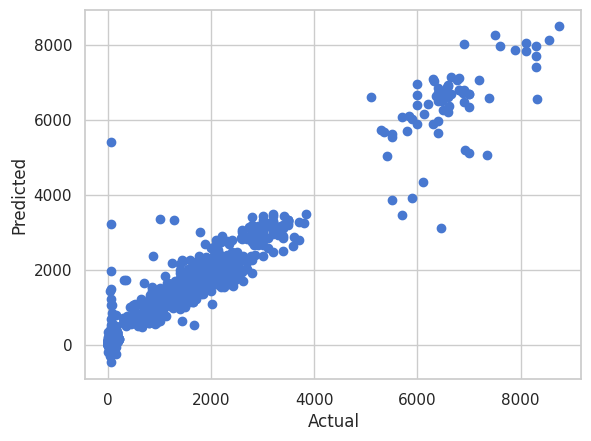

In [ ]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

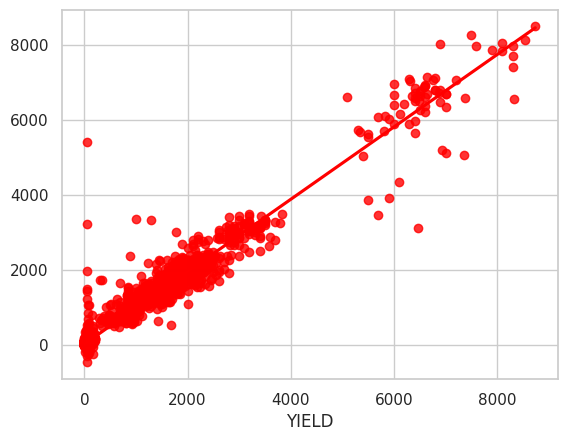

In [ ]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

Difference between Actual and Predicted Values

In [ ]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
20019,67.000000,59.974468,7.025532
15258,2.300000,56.552128,-54.252128
7427,850.000000,1528.362915,-678.362915
21014,6.330000,-0.046648,6.376648
9382,65.000000,52.982307,12.017693
...,...,...,...
9801,2.100000,27.297665,-25.197665
7640,26.400000,50.863503,-24.463503
35368,49.867097,57.223774,-7.356677
26561,133.958684,123.012894,10.945790


## Support Vector Regressor - Hyper Parameter Tuning using GridSearchCV

In [ ]:
# Create a dictionary to store results
results_GridSearchCV = {}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [0.1, 1, 10],
}


grid_search = GridSearchCV(SVR(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_svr_model = grid_search.best_estimator_

y_pred_best_svr = best_svr_model.predict(X_test)

## XGBoost Regressor - Hyper Parameter Tuning using GridSearchCV

In [ ]:
import xgboost as xgb

# Initialize the XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
`ee': [0.8, 0.9]
}

# Create a GridSearchCV object with a smaller number of cross-validation folds
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred_xgb_best = best_model.predict(X_test)

# Model evaluation with the best model
mae_xgb_best = mean_absolute_error(y_test, y_pred_xgb_best)
mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

# Print best parameters and evaluation results
print("Best Hyperparameters:")
print(best_params)
print("\nXGBoost Regressor Evaluation with Best Model:")
print(f"Mean Absolute Error: {mae_xgb_best:.2f}")
print(f"Mean Squared Error: {mse_xgb_best:.2f}")
print(f"R-squared (R2) Score: {r2_xgb_best:.2f}")

results_GridSearchCV['XGBoost Regressor'] = [mae_xgb_best, mse_xgb_best, r2_xgb_best]

Best Hyperparameters:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}

XGBoost Regressor Evaluation with Best Model:
Mean Absolute Error: 62.69
Mean Squared Error: 32780.47
R-squared (R2) Score: 0.95


In [ ]:
xgb_model =  XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_model.predict(X_test)

array([  59.97447 ,   56.552128, 1528.3629  , ...,   57.223774,
        123.01289 ,   59.52549 ], dtype=float32)

## Hyperparameter Tuning for Decision tree Regression using GridSearchCV

In [ ]:
param_grid = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8]
}

# Initialize Decision Tree with notebook's random state
dt_reg = DecisionTreeRegressor(random_state=42)

# Configure GridSearchCV with notebook's preferred settings
grid_search = GridSearchCV(estimator=dt_reg,
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=3,
                          n_jobs=-1,
                          verbose=2)

# Fit using notebook's preprocessed data
grid_search.fit(X_train, y_train)

# Best parameters from tuning
print("Optimal Parameters:", grid_search.best_params_)
best_dt = grid_search.best_estimator_

# Evaluate with notebook's metrics
y_pred = best_dt.predict(X_test)
print(f"\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Optimal Parameters: {'max_depth': 30, 'max_features': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 10}

RMSE: 234.0404
R²: 0.9245


## Hyperparameter Tuning for RandomForest Regressor using GridSearchCV



In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.8]  # Optimized for 14 core features
}

# Initialize Random Forest with notebook's settings
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

# Configure GridSearchCV with notebook's validation strategy
grid_search = GridSearchCV(estimator=rf_reg,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',  # Consistent with notebook's RMSE focus
                          cv=3,  # Matches notebook's validation approach
                          n_jobs=-1,
                          verbose=2)

# Fit using notebook's preprocessed data
grid_search.fit(X_train, y_train)

# Best parameters from tuning
print("Optimal Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate with notebook's metrics
y_pred = best_rf.predict(X_test)
print(f"\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Optimal Parameters: {'max_depth': 30, 'max_features': 0.8, 'min_samples_split': 2, 'n_estimators': 300}

RMSE: 164.2147
R²: 0.9628
